In [44]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, StandardScaler

import warnings
warnings.filterwarnings('ignore')

# 0. Dataset and its Summary
#### [Get the dataset from here!](https://www.kaggle.com/datasets/denkuznetz/taxi-price-prediction)
- Distance (in kilometers): The length of the trip.
- Pickup Time: The starting time of the trip.
- Dropoff Time: The ending time of the trip.
- Traffic Condition: Categorical indicator of traffic (light, medium, heavy).
- Passenger Count: Number of passengers for the trip.
- Weather Condition: Categorical data for weather (clear, rain, snow).
- Trip Duration (in minutes): Total trip time.
- Fare Amount (target): The cost of the trip (in USD).

# 1. Exploring Data

In [45]:
df = pd.read_csv('/kaggle/input/taxi-price-prediction/taxi_trip_pricing.csv')
df.head()

,Trip_Distance_km,Time_of_Day,Day_of_Week,Passenger_Count,Traffic_Conditions,Weather,Base_Fare,Per_Km_Rate,Per_Minute_Rate,Trip_Duration_Minutes,Trip_Price
0,19.35,Morning,Weekday,3.0,Low,Clear,3.56,0.80,0.32,53.82,36.2624
1,47.59,Afternoon,Weekday,1.0,High,Clear,NaN,0.62,0.43,40.57,NaN
2,36.87,Evening,Weekend,1.0,High,Clear,2.70,1.21,0.15,37.27,52.9032
3,30.33,Evening,Weekday,4.0,Low,NaN,3.48,0.51,0.15,116.81,36.4698
4,NaN,Evening,Weekday,3.0,High,Clear,2.93,0.63,0.32,22.64,15.6180


In [46]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 11 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Trip_Distance_km       950 non-null    float64
 1   Time_of_Day            950 non-null    object 
 2   Day_of_Week            950 non-null    object 
 3   Passenger_Count        950 non-null    float64
 4   Traffic_Conditions     950 non-null    object 
 5   Weather                950 non-null    object 
 6   Base_Fare              950 non-null    float64
 7   Per_Km_Rate            950 non-null    float64
 8   Per_Minute_Rate        950 non-null    float64
 9   Trip_Duration_Minutes  950 non-null    float64
 10  Trip_Price             951 non-null    float64
dtypes: float64(7), object(4)
memory usage: 86.1+ KB


In [47]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Trip_Distance_km,950.0,27.070547,19.905300,1.2300,12.63250,25.8300,38.40500,146.067047
Passenger_Count,950.0,2.476842,1.102249,1.0000,1.25000,2.0000,3.00000,4.000000
Base_Fare,950.0,3.502989,0.870162,2.0100,2.73000,3.5200,4.26000,5.000000
Per_Km_Rate,950.0,1.233316,0.429816,0.5000,0.86000,1.2200,1.61000,2.000000
Per_Minute_Rate,950.0,0.292916,0.115592,0.1000,0.19000,0.2900,0.39000,0.500000
Trip_Duration_Minutes,950.0,62.118116,32.154406,5.0100,35.88250,61.8600,89.05500,119.840000
Trip_Price,951.0,56.874773,40.469791,6.1269,33.74265,50.0745,69.09935,332.043689


In [48]:
df.shape

(1000, 11)

In [49]:
df = df.drop_duplicates()

In [50]:
df.shape

(1000, 11)

In [51]:
df.isnull().sum()

Trip_Distance_km         50
Time_of_Day              50
Day_of_Week              50
Passenger_Count          50
Traffic_Conditions       50
Weather                  50
Base_Fare                50
Per_Km_Rate              50
Per_Minute_Rate          50
Trip_Duration_Minutes    50
Trip_Price               49
dtype: int64

# 2. Removing Outliers

In [52]:
df.describe()
# by looking only trip_distance and trip_price seem like outliers

,Trip_Distance_km,Passenger_Count,Base_Fare,Per_Km_Rate,Per_Minute_Rate,Trip_Duration_Minutes,Trip_Price
count,950.000000,950.000000,950.000000,950.000000,950.000000,950.000000,951.000000
mean,27.070547,2.476842,3.502989,1.233316,0.292916,62.118116,56.874773
std,19.905300,1.102249,0.870162,0.429816,0.115592,32.154406,40.469791
min,1.230000,1.000000,2.010000,0.500000,0.100000,5.010000,6.126900
25%,12.632500,1.250000,2.730000,0.860000,0.190000,35.882500,33.742650
50%,25.830000,2.000000,3.520000,1.220000,0.290000,61.860000,50.074500
75%,38.405000,3.000000,4.260000,1.610000,0.390000,89.055000,69.099350
max,146.067047,4.000000,5.000000,2.000000,0.500000,119.840000,332.043689


In [53]:
Q1 = df['Trip_Price'].quantile(0.25)
Q3 = df['Trip_Price'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outliers = df[(df['Trip_Price'] < lower_bound) | (df['Trip_Price'] > upper_bound)]
print(len(outliers))

26


In [54]:
Q1_distance = df['Trip_Distance_km'].quantile(0.25)
Q3_distance = df['Trip_Distance_km'].quantile(0.75)
IQR_distance = Q3_distance - Q1_distance
lower_bound_distance = Q1_distance - 1.5 * IQR_distance
upper_bound_distance = Q3_distance + 1.5 * IQR_distance

outliers_distance = df[(df['Trip_Distance_km'] < lower_bound_distance) | (df['Trip_Distance_km'] > upper_bound_distance)]
print(len(outliers_distance))

20


In [55]:
df['Trip_Distance_km'] = df['Trip_Distance_km'].apply(lambda x: upper_bound_distance if x in outliers_distance['Trip_Distance_km'].values else x)

In [56]:
df['Trip_Distance_km'].describe()

count    950.000000
mean      26.152816
std       16.072583
min        1.230000
25%       12.632500
50%       25.830000
75%       38.405000
max       77.063750
Name: Trip_Distance_km, dtype: float64

In [57]:
df['Trip_Price'] = df['Trip_Price'].clip(lower=lower_bound, upper=upper_bound)
print(df['Trip_Price'].describe())

count    951.000000
mean      53.616300
std       25.760911
min        6.126900
25%       33.742650
50%       50.074500
75%       69.099350
max      122.134400
Name: Trip_Price, dtype: float64


# 3 . Fixing nulls in numeric columns

In [58]:
numeric_columns = ['Trip_Distance_km', 'Passenger_Count', 'Base_Fare', 
                   'Per_Km_Rate', 'Per_Minute_Rate', 'Trip_Duration_Minutes', 'Trip_Price']

In [59]:
df.dropna(subset=["Trip_Price"], inplace=True)

In [60]:
for col in numeric_columns:
    print(f"no. of uniques in {col}: {df[col].nunique()}")

no. of uniques in Trip_Distance_km: 808
no. of uniques in Passenger_Count: 4
no. of uniques in Base_Fare: 286
no. of uniques in Per_Km_Rate: 150
no. of uniques in Per_Minute_Rate: 41
no. of uniques in Trip_Duration_Minutes: 873
no. of uniques in Trip_Price: 926


In [61]:
print(df["Passenger_Count"].value_counts())

Passenger_Count
3.0    237
2.0    232
1.0    224
4.0    210
Name: count, dtype: int64


In [62]:
# Full numeric columns
for column in numeric_columns:
    df[column].fillna(df[column].mean(), inplace=True)

# 4. Fixing Nulls in Categorical columns

In [63]:
print("time of day: ", df["Time_of_Day"].unique())
print("day of week: ", df["Day_of_Week"].unique())
print("traffic conditions: ", df["Traffic_Conditions"].unique())
print("weather: ", df["Weather"].unique())

time of day:  ['Morning' 'Evening' 'Afternoon' 'Night' nan]
day of week:  ['Weekday' 'Weekend' nan]
traffic conditions:  ['Low' 'High' 'Medium' nan]
weather:  ['Clear' nan 'Rain' 'Snow']


In [64]:
categorical_columns = ['Time_of_Day', 'Day_of_Week', 'Traffic_Conditions', 'Weather']

for column in categorical_columns:
    df[column].fillna(df[column].mode()[0], inplace=True)

In [65]:
print(df['Time_of_Day'].value_counts())
print(df['Traffic_Conditions'].value_counts())
print(df['Weather'].value_counts())
print(df['Day_of_Week'].value_counts())

Time_of_Day
Afternoon    400
Morning      265
Evening      197
Night         89
Name: count, dtype: int64
Traffic_Conditions
Low       424
Medium    355
High      172
Name: count, dtype: int64
Weather
Clear    680
Rain     216
Snow      55
Name: count, dtype: int64
Day_of_Week
Weekday    668
Weekend    283
Name: count, dtype: int64


# 5. Categorical Features Analysis

In [66]:
print("time of day: ", df["Time_of_Day"].unique())
print("day of week: ", df["Day_of_Week"].unique())
print("traffic conditions: ", df["Traffic_Conditions"].unique())
print("weather: ", df["Weather"].unique())

time of day:  ['Morning' 'Evening' 'Afternoon' 'Night']
day of week:  ['Weekday' 'Weekend']
traffic conditions:  ['Low' 'High' 'Medium']
weather:  ['Clear' 'Rain' 'Snow']


In [67]:
train, test = train_test_split(df, test_size=0.2, random_state=2)

In [68]:
train.groupby("Time_of_Day")["Trip_Price"].mean()

Time_of_Day
Afternoon    53.166971
Evening      54.610047
Morning      53.867111
Night        54.116236
Name: Trip_Price, dtype: float64

In [69]:
train.groupby("Day_of_Week")["Trip_Price"].mean()

Day_of_Week
Weekday    53.700276
Weekend    53.903094
Name: Trip_Price, dtype: float64

In [70]:
train.groupby("Traffic_Conditions")["Trip_Price"].mean()

Traffic_Conditions
High      58.616052
Low       52.442695
Medium    53.136699
Name: Trip_Price, dtype: float64

In [71]:
train.groupby("Weather")["Trip_Price"].mean()

Weather
Clear    53.276491
Rain     54.534633
Snow     56.651274
Name: Trip_Price, dtype: float64

# 6. Data Preprocessing

In [72]:
# Define Preprocessing Steps
traffic_hierarchy = ["Low", "Medium", "High"]
weather_hierarchy = ["Clear", "Rain", "Snow"]
traffic_encoded = OrdinalEncoder(categories=[traffic_hierarchy])
weather_encoded = OrdinalEncoder(categories=[weather_hierarchy])

onehot_features = ["Day_of_Week", "Time_of_Day"]
onehot_encoder = OneHotEncoder(handle_unknown='ignore', drop='first')  # Drop first to avoid collinearity
scaler = StandardScaler()

# Column Transformer
preprocessor = ColumnTransformer([
    ('ordinal_traffic', traffic_encoded, ["Traffic_Conditions"]),
    ('ordinal_weather', weather_encoded, ["Weather"]),
    ('onehot', onehot_encoder, onehot_features),
    ('scaler', scaler, numeric_columns)
])

# Create Pipeline
pipeline = Pipeline([
    ('preprocessing', preprocessor)
])

# Fit and Transform on Training Data
train_transformed = pipeline.fit_transform(train)

# Transform Test Data (No fit here!)
test_transformed = pipeline.transform(test)

ordinal_column_names = ["Traffic_Conditions", "Weather"]
onehot_column_names = preprocessor.named_transformers_['onehot'].get_feature_names_out(onehot_features).tolist()
numeric_column_names = numeric_columns

all_columns = ordinal_column_names + onehot_column_names + numeric_column_names
# Convert to DataFrame
train = pd.DataFrame(train_transformed, columns = all_columns)
test = pd.DataFrame(test_transformed, columns= all_columns)

# 7. Correlation analysis and Predictions

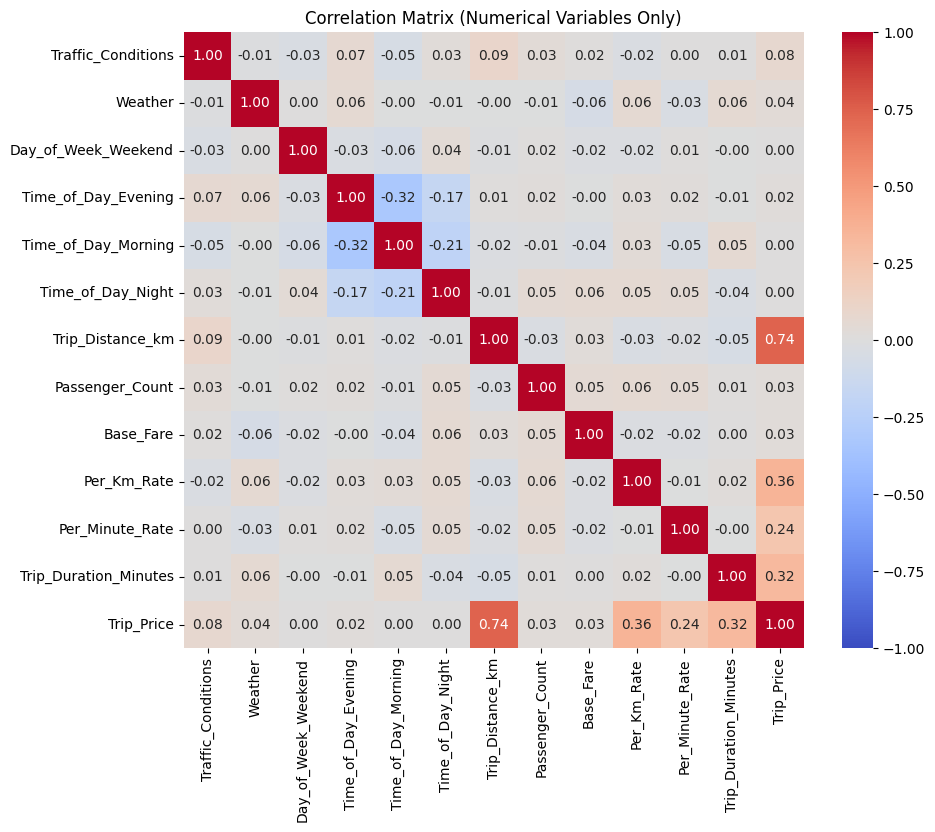

In [73]:
correlation_matrix = train.corr(numeric_only=True)
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', vmin=-1, vmax=1)
plt.title('Correlation Matrix (Numerical Variables Only)')
plt.show()

In [74]:
df.columns

Index(['Trip_Distance_km', 'Time_of_Day', 'Day_of_Week', 'Passenger_Count',
       'Traffic_Conditions', 'Weather', 'Base_Fare', 'Per_Km_Rate',
       'Per_Minute_Rate', 'Trip_Duration_Minutes', 'Trip_Price'],
      dtype='object')

In [ ]:
# replace FIXME with the appropriate column-name
X_train = train.drop([FIXME], axis = 1)
X_test = test.drop([FIXME], axis = 1)
y_train = train[FIXME]
y_test = test[FIXME]

In [78]:
model = LinearRegression()

In [79]:
# replace FIXME with correct dataframes
model.fit(FIXME, FIXME)
# model.fit(independent_featueres, dependent_feature)

LinearRegression()

In [81]:
# replace FIXME with correct dataframe
y_pred = model.predict(FIXME)
# model.fit(unseen_independent_features_for_the_model)

In [82]:
# replace FIXME with the correct values
linear_mse = mean_squared_error(FIXME, FIXME)
linear_r2 = r2_score(FIXME, FIXME)
# mean_squared_error(true_values, predicted_values)
# r2_score(true_values, predicted_values)

print(f'Mean Squared Error: {linear_mse}')
print(f'R^2 Score: {linear_r2}')

Mean Squared Error: 0.14018849493795205
R^2 Score: 0.8803017030270291
